TODO list:
- Calculate the additional variables I care about from these
- Compute the data quality metrics
- Filter this down and separate into three different time points:

## Obtaining the data

In [42]:
import pandas as pd
from sodapy import Socrata

federal_client = Socrata(
    "healthdata.gov",
    'PmTWj6hExEV3muUjErx8lqo9h',
    username = '67mk7nwz4pplnp23qzuogdbrb',
    password = '4j8ensof75ev2hs3ew4njx89hx1v9gvhzedtsssu0rptc9iu9a'
)

hospital_query = """
SELECT
    hospital_pk,
    hospital_name,
    collection_week,
    state,
    fips_code,
    geocoded_hospital_address,
    total_personnel_covid_vaccinated_doses_none_7_day AS no_dose_personnel,
    total_personnel_covid_vaccinated_doses_one_7_day AS one_dose_personnel,
    total_personnel_covid_vaccinated_doses_all_7_day AS two_dose_personnel
WHERE
    collection_week >= '2021-04-01T00:00:00.000'
LIMIT
    300000
"""

survey_results = federal_client.get(
    "anag-cw7u", 
    content_type = 'json',
    query = hospital_query
)

survey_results_df = pd.DataFrame.from_records(survey_results)

In [46]:
survey_results_df = survey_results_df.astype({
    'hospital_pk': 'category',
    'hospital_name': 'object',
    'collection_week': 'datetime64',
    'state': 'object',
    'fips_code': 'category',
    'geocoded_hospital_address': 'object',
    'no_dose_personnel': 'float_',
    'one_dose_personnel': 'float_',
    'two_dose_personnel': 'float_'
})


survey_results_df.to_pickle('survey_results.pkl')
survey_results_df

,hospital_pk,hospital_name,collection_week,state,fips_code,geocoded_hospital_address,no_dose_personnel,one_dose_personnel,two_dose_personnel
0,291314,SOUTH LYON MEDICAL CENTER,2021-04-02,NV,32019,NaN,NaN,NaN,NaN
1,292003,HORIZON SPECIALTY HOSPITAL,2021-04-02,NV,32003,NaN,NaN,NaN,NaN
2,370178,MEMORIAL HOSPITAL,2021-04-02,OK,40001,"{'type': 'Point', 'coordinates': [-94.643134, ...",81.0,0.0,92.0
3,330151,ST JAMES HOSPITAL,2021-04-02,NY,36101,"{'type': 'Point', 'coordinates': [-77.662034, ...",96.0,12.0,242.0
4,450808,NORTHWEST HILLS SURGICAL HOSPITAL,2021-04-02,TX,48453,"{'type': 'Point', 'coordinates': [-97.751025, ...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
210440,192028,RIVERBRIDGE SPECIALTY HOSPITAL,2022-01-14,LA,22029,"{'type': 'Point', 'coordinates': [-91.41918, 3...",65.0,120.0,118.0
210441,390079,ROBERT PACKER HOSPITAL,2022-01-14,PA,42015,NaN,217.0,1604.0,1632.0
210442,501327,WHITMAN HOSPITAL AND MEDICAL CENTER,2022-01-14,WA,53075,"{'type': 'Point', 'coordinates': [-117.375012,...",NaN,NaN,NaN
210443,100292,SACRED HEART HOSPITAL ON THE EMERALD COAST,2022-01-14,FL,12131,"{'type': 'Point', 'coordinates': [-86.306988, ...",NaN,NaN,NaN


In [44]:
survey_results_df.collection_week.unique()

array(['2021-04-02T00:00:00.000', '2021-04-09T00:00:00.000',
       '2021-04-16T00:00:00.000', '2021-04-23T00:00:00.000',
       '2021-04-30T00:00:00.000', '2021-05-07T00:00:00.000',
       '2021-05-14T00:00:00.000', '2021-05-21T00:00:00.000',
       '2021-05-28T00:00:00.000', '2021-06-04T00:00:00.000',
       '2021-06-11T00:00:00.000', '2021-06-18T00:00:00.000',
       '2021-06-25T00:00:00.000', '2021-07-02T00:00:00.000',
       '2021-07-09T00:00:00.000', '2021-07-16T00:00:00.000',
       '2021-07-23T00:00:00.000', '2021-07-30T00:00:00.000',
       '2021-08-06T00:00:00.000', '2021-08-13T00:00:00.000',
       '2021-08-20T00:00:00.000', '2021-08-27T00:00:00.000',
       '2021-09-03T00:00:00.000', '2021-09-10T00:00:00.000',
       '2021-09-17T00:00:00.000', '2021-09-24T00:00:00.000',
       '2021-10-01T00:00:00.000', '2021-10-08T00:00:00.000',
       '2021-10-15T00:00:00.000', '2021-10-22T00:00:00.000',
       '2021-10-29T00:00:00.000', '2021-11-05T00:00:00.000',
       '2021-11-12T00:00

Dates we'll look at:
- April 9th 2021 (the day used in the original map)
- November 5th 2021 (the day after the [Biden administration](https://www.whitehouse.gov/briefing-room/statements-releases/2021/11/04/fact-sheet-biden-administration-announces-details-of-two-major-vaccination-policies/) announced
a requirement for healthcare workers to be vaccinated)
- January 14th 2022 (the most recent response, and 10 days after
the original date given by the for Biden administration for when
healthcare workers would need to be vaccinated by)

In [47]:
cdc_client = Socrata(
    "data.cdc.gov",
    'PmTWj6hExEV3muUjErx8lqo9h',
    username = '67mk7nwz4pplnp23qzuogdbrb',
    password = '4j8ensof75ev2hs3ew4njx89hx1v9gvhzedtsssu0rptc9iu9a'
)

covid_query = """
SELECT
    date,
    fips,
    recip_county,
    recip_state,
    Administered_Dose1_Recip_18PlusPop_Pct AS one_dose_pop,
    Series_Complete_18PlusPop_Pct AS two_dose_pop,
    census2019 AS county_pop_size
WHERE
    date IN (
        '2021-04-09T00:00:00.000',
        '2021-11-05T00:00:00.000',
        '2022-01-14T00:00:00.000'
    )
LIMIT
    10000
"""

county_covid = cdc_client.get("8xkx-amqh", query = covid_query)
county_covid_df = pd.DataFrame.from_records(county_covid)

county_covid_df = county_covid_df.astype({
    'date': 'datetime64',
    'fips': 'category',
    'recip_county': 'object',
    'recip_state': 'object',
    'one_dose_pop': 'float_',
    'two_dose_pop': 'float',
    'county_pop_size': 'float_'
})

county_covid_df.to_pickle('county_covid.pkl')
county_covid_df

,date,fips,recip_county,recip_state,one_dose_pop,two_dose_pop,county_pop_size
0,2021-04-09,13239,Quitman County,GA,9.7,6.2,2299.0
1,2021-04-09,13209,Montgomery County,GA,12.6,8.3,9172.0
2,2021-04-09,27161,Waseca County,MN,42.2,27.0,18612.0
3,2021-04-09,15009,Maui County,HI,0.0,0.0,167417.0
4,2021-04-09,UNK,Unknown County,MD,0.0,0.0,NaN
...,...,...,...,...,...,...,...
9843,2022-01-14,19087,Henry County,IA,67.0,62.2,19954.0
9844,2022-01-14,55037,Florence County,WI,65.1,60.7,4295.0
9845,2022-01-14,48391,Refugio County,TX,69.8,62.1,6948.0
9846,2022-01-14,47011,Bradley County,TN,54.8,48.7,108110.0


# Computing data quality metrics

Metrics to compute:
- Indicator for whether vaccination rates are reported
    - I mean, if it's not reported, it's not exactly good data, no?
- Standard deviations of vaccinated/not vaccinated percentages
in a hospital away from the population percentages in a county
    - If this is slightly negative, or **substantially** positive,
    then this could be evidence that there is something amiss here,
    as we would expect healthcare workers to be, if anything,
    more likely to be vaccinated than the population they are in.
    Significantly positive deviations would suggest a possible
    overestimation in counts, whereas slightly negative or
    significantly negative deviations could suggest underreporting.
- Non-positive number of workers
    - If a hospital has no workers, either something is up
    with the reporting, or there's something REALLY 
    interesting going on.
- More fully vaccinated workers than "one shot or more" workers
    - This is probably due to ambiguity in how the variable
    is coded (the description is contradictory in its
    intent, and what is meant to be captured by it).
- More workers than the size of the county it is in
    - Apparently this is something I need to check.


Workflow for computing metrics:
- Are there vaccination rates reported? If not, stop here.
- Does the hosital report all zeros for these values? If so,
then this is the same as not reporting the vaccination rates

In [55]:
import numpy as np
import matplotlib.pyplot as plt  

In [85]:
survey_results_df = pd.read_pickle('survey_results.pkl')
county_covid_df = pd.read_pickle('county_covid.pkl')

In [86]:
# Replacing suppressed values with 0 for purposes of calculation
survey_results_df = survey_results_df.replace(-999999, 0)

In [87]:
obs_data = survey_results_df.dropna(
    subset = ['no_dose_personnel', 'one_dose_personnel', 'two_dose_personnel']
)

obs_data

,hospital_pk,hospital_name,collection_week,state,fips_code,geocoded_hospital_address,no_dose_personnel,one_dose_personnel,two_dose_personnel
2,370178,MEMORIAL HOSPITAL,2021-04-02,OK,40001,"{'type': 'Point', 'coordinates': [-94.643134, ...",81.0,0.0,92.0
3,330151,ST JAMES HOSPITAL,2021-04-02,NY,36101,"{'type': 'Point', 'coordinates': [-77.662034, ...",96.0,12.0,242.0
5,100289,CLEVELAND CLINIC HOSPITAL,2021-04-02,FL,12011,"{'type': 'Point', 'coordinates': [-80.365467, ...",1327.0,2108.0,1925.0
6,440073,MAURY REGIONAL HOSPITAL,2021-04-02,TN,47119,"{'type': 'Point', 'coordinates': [-87.065768, ...",1290.0,1614.0,1553.0
9,100071,BRAVERA HEALTH BROOKSVILLE,2021-04-02,FL,12053,"{'type': 'Point', 'coordinates': [-82.443386, ...",497.0,120.0,360.0
...,...,...,...,...,...,...,...,...,...
210436,271312,PHILLIPS COUNTY MEDICAL CENTER,2022-01-14,MT,30071,"{'type': 'Point', 'coordinates': [-107.860356,...",0.0,0.0,0.0
210437,440068,STARR REGIONAL MEDICAL CENTER ATHENS,2022-01-14,TN,47107,"{'type': 'Point', 'coordinates': [-84.608109, ...",238.0,0.0,419.0
210439,150126,FRANCISCAN HEALTH CROWN POINT,2022-01-14,IN,18089,"{'type': 'Point', 'coordinates': [-87.364438, ...",0.0,0.0,0.0
210440,192028,RIVERBRIDGE SPECIALTY HOSPITAL,2022-01-14,LA,22029,"{'type': 'Point', 'coordinates': [-91.41918, 3...",65.0,120.0,118.0


In [92]:
# Plotting ranges of values, as something is messed up still
obs_data[obs_data['no_dose_personnel'] > 100000]

,hospital_pk,hospital_name,collection_week,state,fips_code,geocoded_hospital_address,no_dose_personnel,one_dose_personnel,two_dose_personnel
176726,521323,MARSHFIELD MEDICAL CENTER - NEILLSVILLE,2021-12-03,WI,55019,"{'type': 'Point', 'coordinates': [-90.618745, ...",520037.0,520037.0,520037.0


(array([2.32000e+02, 1.27402e+05, 4.90000e+01, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([-39033. , -16592.2,   5848.6,  28289.4,  50730.2,  73171. ,
         95611.8, 118052.6, 140493.4, 162934.2, 185375. ]),
 <BarContainer object of 10 artists>)

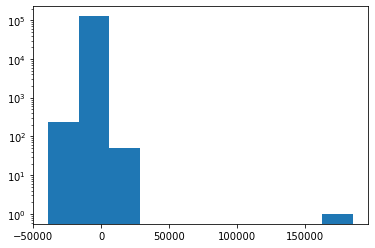

In [88]:
survey_results_df = survey_results_df.assign(
    single_shot = lambda x: x.one_dose_personnel - x.two_dose_personnel
).dropna(
    subset = ['single_shot']
)

plt.hist(
    survey_results_df['single_shot'], log = True
)

In [ ]:
survey_results_df.assign(
    
)

In [50]:
county_covid_df = county_covid_df.assign(
    one_dose_pop = lambda x: x.one_dose_pop - x.two_dose_pop,
    zero_dose_pop = lambda x: 100 - x.one_dose_pop - x.two_dose_pop
)

,date,fips,recip_county,recip_state,one_dose_pop,two_dose_pop,county_pop_size,zero_dose_pop
0,2021-04-09,13239,Quitman County,GA,3.5,6.2,2299.0,90.3
1,2021-04-09,13209,Montgomery County,GA,4.3,8.3,9172.0,87.4
2,2021-04-09,27161,Waseca County,MN,15.2,27.0,18612.0,57.8
3,2021-04-09,15009,Maui County,HI,0.0,0.0,167417.0,100.0
4,2021-04-09,UNK,Unknown County,MD,0.0,0.0,NaN,100.0
...,...,...,...,...,...,...,...,...
9843,2022-01-14,19087,Henry County,IA,4.8,62.2,19954.0,33.0
9844,2022-01-14,55037,Florence County,WI,4.4,60.7,4295.0,34.9
9845,2022-01-14,48391,Refugio County,TX,7.7,62.1,6948.0,30.2
9846,2022-01-14,47011,Bradley County,TN,6.1,48.7,108110.0,45.2


# Exploratory data analysis

Question: Has the percentage of hospitals reporting vaccination data changed over time?